Import libraries and set color pallete

In [1]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
import xgboost as xgb

# Updated color palette
deep_green = "#004D36"
niner_green = "#006A4D"
emerald_green = "#00A86B"
miner_gold = "#C7A34A"
golden_yellow = "#FFD700"
amber = "#FFB347"
bronze = "#CD7F32"
crimson = "#DC143C"

color_palette = [
    deep_green, niner_green, emerald_green, miner_gold, 
    golden_yellow, amber, bronze, crimson
]
sns.set_palette(sns.color_palette(color_palette))


Load dataset and check that it correctly loaded

In [2]:
# Cell 2: Load the dataset
df = pd.read_csv("Preprocessed_Retail_Store_Inventory.csv")

# Cell 3: Inspect the dataset structure
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                73100 non-null  object 
 1   Store ID            73100 non-null  int64  
 2   Product ID          73100 non-null  int64  
 3   Category            73100 non-null  int64  
 4   Region              73100 non-null  int64  
 5   Inventory Level     73100 non-null  float64
 6   Units Sold          73100 non-null  float64
 7   Units Ordered       73100 non-null  float64
 8   Demand Forecast     73100 non-null  float64
 9   Price               73100 non-null  float64
 10  Discount            73100 non-null  int64  
 11  Weather Condition   73100 non-null  int64  
 12  Holiday/Promotion   73100 non-null  int64  
 13  Competitor Pricing  73100 non-null  float64
 14  Seasonality         73100 non-null  int64  
dtypes: float64(6), int64(8), object(1)
memory usage: 8.4+

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,0,0,3,1,0.402222,0.254509,0.194444,0.275211,0.261111,20,1,0,0.246822,0
1,2022-01-01,0,1,4,2,0.342222,0.300601,0.255556,0.291425,0.589000,20,3,0,0.611851,0
2,2022-01-01,0,2,4,3,0.115556,0.130261,0.172222,0.158947,0.199889,10,3,1,0.263137,2
3,2022-01-01,0,3,4,1,0.931111,0.122244,0.800000,0.136546,0.252444,10,0,1,0.297368,0
4,2022-01-01,0,4,1,0,0.257778,0.028056,0.638889,0.036421,0.707111,0,3,0,0.639776,2


Feature engineering - sales, inventory, promotions, sales conditions

In [3]:
# Cell 5: Add time-based features
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df['Weekday'] = df['Date'].dt.weekday
df['Year'] = df['Date'].dt.year

# Define holidays with high sales trends
holiday_sales = {
    'Christmas': [(12, 25)],
    'Black Friday': [(11, 26), (11, 27)],
    'New Year': [(1, 1)],
    'Independence Day': [(7, 4)]
}

# Add a Holiday column
df['Holiday'] = 0
for holiday, dates in holiday_sales.items():
    for month, day in dates:
        df['Holiday'] = np.where(
            (df['Date'].dt.month == month) & (df['Date'].dt.day == day),
            1,
            df['Holiday']
        )

# Define "Promotion Needed"
df['Promotion Needed'] = (
    ((df['Inventory Level'] > 0.5) & (df['Units Sold'] < 0.3)) |
    (df['Holiday'] == 1)
).astype(int)


Separate training and testing data sets

In [4]:
# Cell 6: Split data into training and testing sets
features = ['Inventory Level', 'Units Sold', 'Demand Forecast', 'Price', 'Discount',
            'Competitor Pricing', 'Seasonality', 'Holiday']
X = df[features]
y_classification = df['Promotion Needed']
y_regression = df['Inventory Level']

# Split data
X_train, X_test, y_train_classification, y_test_classification = train_test_split(
    X, y_classification, test_size=0.2, random_state=42
)
_, _, y_train_regression, y_test_regression = train_test_split(
    X, y_regression, test_size=0.2, random_state=42
)


Identify key drivers for promotions & Visualizaions

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     11497
           1       1.00      1.00      1.00      3123

    accuracy                           1.00     14620
   macro avg       1.00      1.00      1.00     14620
weighted avg       1.00      1.00      1.00     14620

Confusion Matrix:
 [[11497     0]
 [    0  3123]]


C:\Users\cbern\AppData\Local\Temp\ipykernel_13000\2760547957.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


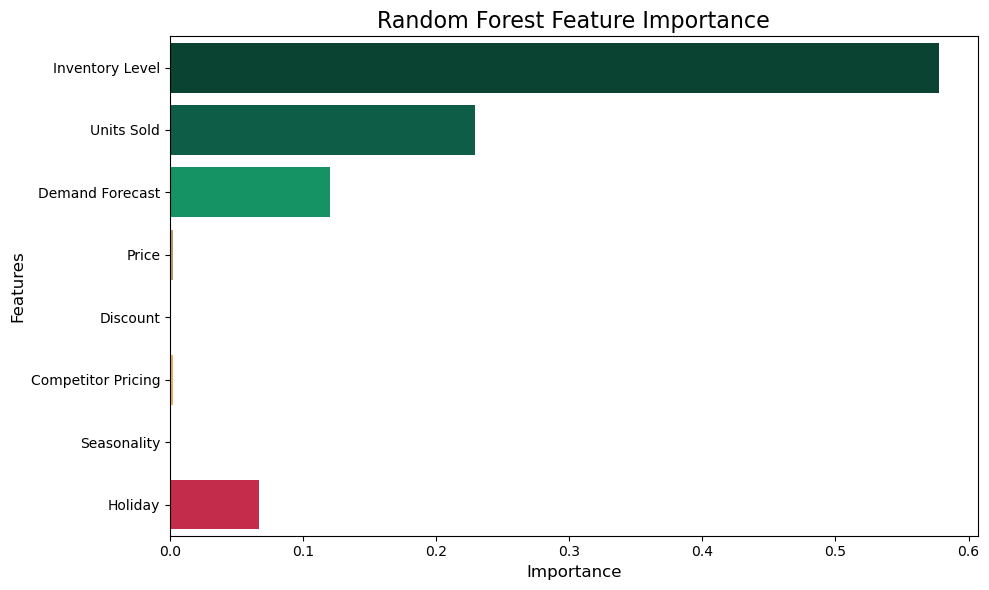

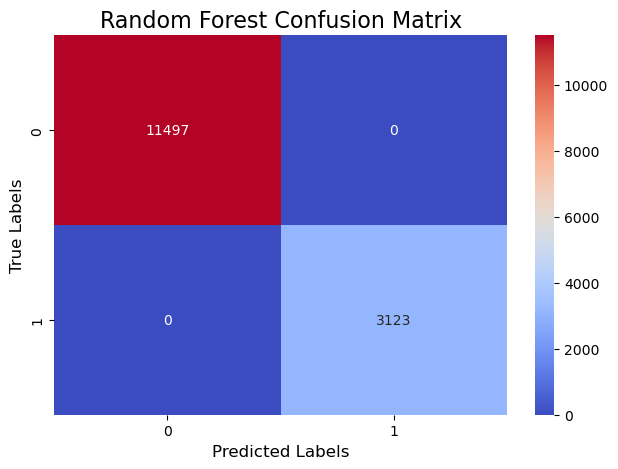

In [15]:
# Cell 7: Random Forest Classifier with Adjusted Feature Importance Plot
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train_classification)
y_pred_rf = rf_clf.predict(X_test)

# Evaluation Metrics
print("Random Forest Classification Report:\n", classification_report(y_test_classification, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test_classification, y_pred_rf))

# Visualization: Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(
    x=rf_clf.feature_importances_,
    y=features,
    palette=color_palette[:len(features)]  # Adjust the palette to match the number of features
)
plt.title("Random Forest Feature Importance", fontsize=16)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.tight_layout()
plt.show()

# Visualization: Confusion Matrix
sns.heatmap(confusion_matrix(y_test_classification, y_pred_rf), annot=True, fmt="d", cmap="coolwarm")
plt.title("Random Forest Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
Gradient Boosting Regressor

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     11497
           1       1.00      1.00      1.00      3123

    accuracy                           1.00     14620
   macro avg       1.00      1.00      1.00     14620
weighted avg       1.00      1.00      1.00     14620

Confusion Matrix:
 [[11492     5]
 [    7  3116]]


<Figure size 1000x600 with 0 Axes>

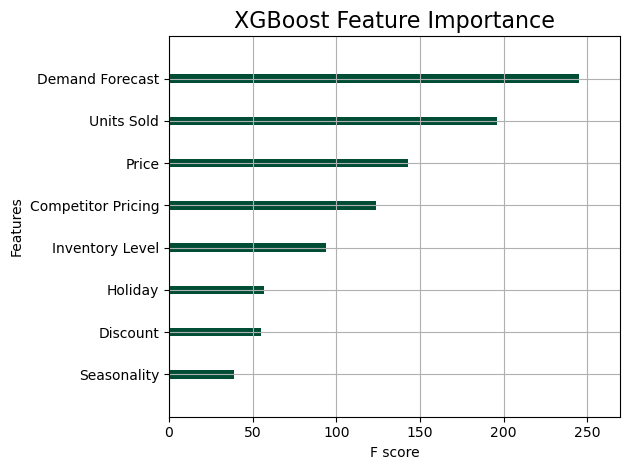

In [6]:
# Cell 8: XGBoost Classifier
xgb_clf = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
xgb_clf.fit(X_train, y_train_classification)
y_pred_xgb = xgb_clf.predict(X_test)

# Evaluation Metrics
print("XGBoost Classification Report:\n", classification_report(y_test_classification, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test_classification, y_pred_xgb))

# Visualization: Feature Importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(xgb_clf, importance_type='weight', show_values=False)
plt.title("XGBoost Feature Importance", fontsize=16)
plt.tight_layout()
plt.show()


Suport Vector Classifier

Support Vector Classifier Report:
               precision    recall  f1-score   support

           0       0.93      0.98      0.95     11497
           1       0.90      0.71      0.79      3123

    accuracy                           0.92     14620
   macro avg       0.91      0.84      0.87     14620
weighted avg       0.92      0.92      0.92     14620

Confusion Matrix:
 [[11246   251]
 [  910  2213]]


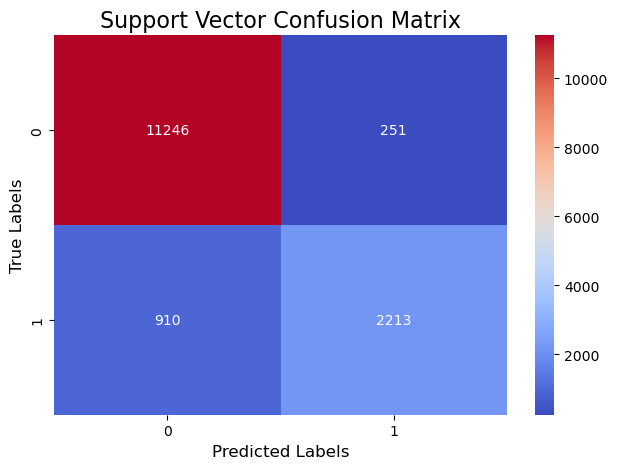

In [7]:
# Cell 9: Support Vector Classifier
svc_clf = SVC(probability=True, random_state=42)
svc_clf.fit(X_train, y_train_classification)
y_pred_svc = svc_clf.predict(X_test)

# Evaluation Metrics
print("Support Vector Classifier Report:\n", classification_report(y_test_classification, y_pred_svc))
print("Confusion Matrix:\n", confusion_matrix(y_test_classification, y_pred_svc))

# Visualization: Confusion Matrix
sns.heatmap(confusion_matrix(y_test_classification, y_pred_svc), annot=True, fmt="d", cmap="coolwarm")
plt.title("Support Vector Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.tight_layout()
plt.show()


Gradient Boosting Regressor

Gradient Boosting Regressor RMSE: 0.0000
Gradient Boosting Regressor R²: 1.0000


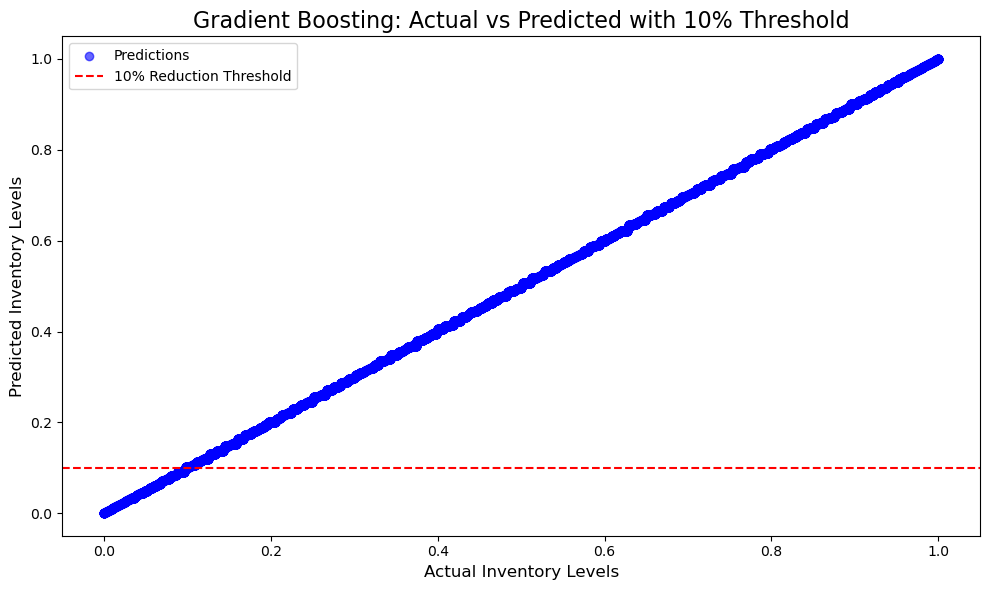

In [18]:
# Cell 10: Gradient Boosting Regressor with Updated 10% Reduction Threshold
from sklearn.metrics import mean_squared_error

# Calculate the 10% reduction threshold dynamically
ten_percent_threshold = y_test_regression.max() * 0.1

# Train the Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train_regression)
y_pred_gbr = gbr.predict(X_test)

# Evaluation Metrics
rmse = mean_squared_error(y_test_regression, y_pred_gbr)  # Correct usage for RMSE
r2 = r2_score(y_test_regression, y_pred_gbr)
print(f"Gradient Boosting Regressor RMSE: {rmse:.4f}")
print(f"Gradient Boosting Regressor R²: {r2:.4f}")

# Visualization: Actual vs Predicted with 10% Reduction Threshold
plt.figure(figsize=(10, 6))
plt.scatter(y_test_regression, y_pred_gbr, alpha=0.6, c='blue', label="Predictions")
plt.axhline(ten_percent_threshold, color='red', linestyle='--', label="10% Reduction Threshold")
plt.title("Gradient Boosting: Actual vs Predicted with 10% Threshold", fontsize=16)
plt.xlabel("Actual Inventory Levels", fontsize=12)
plt.ylabel("Predicted Inventory Levels", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()


Prophet model

22:38:02 - cmdstanpy - INFO - Chain [1] start processing
22:38:03 - cmdstanpy - INFO - Chain [1] done processing


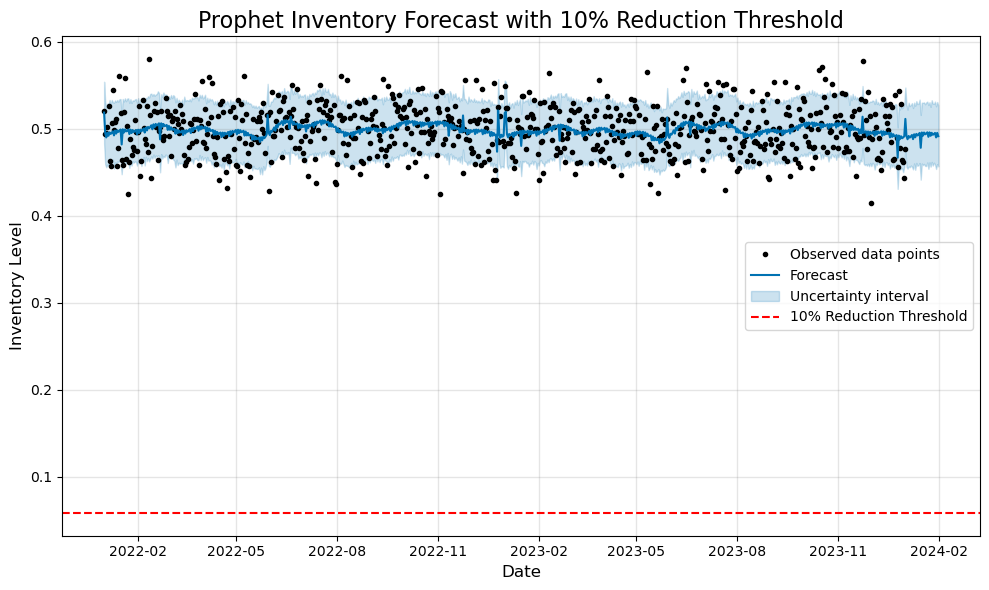

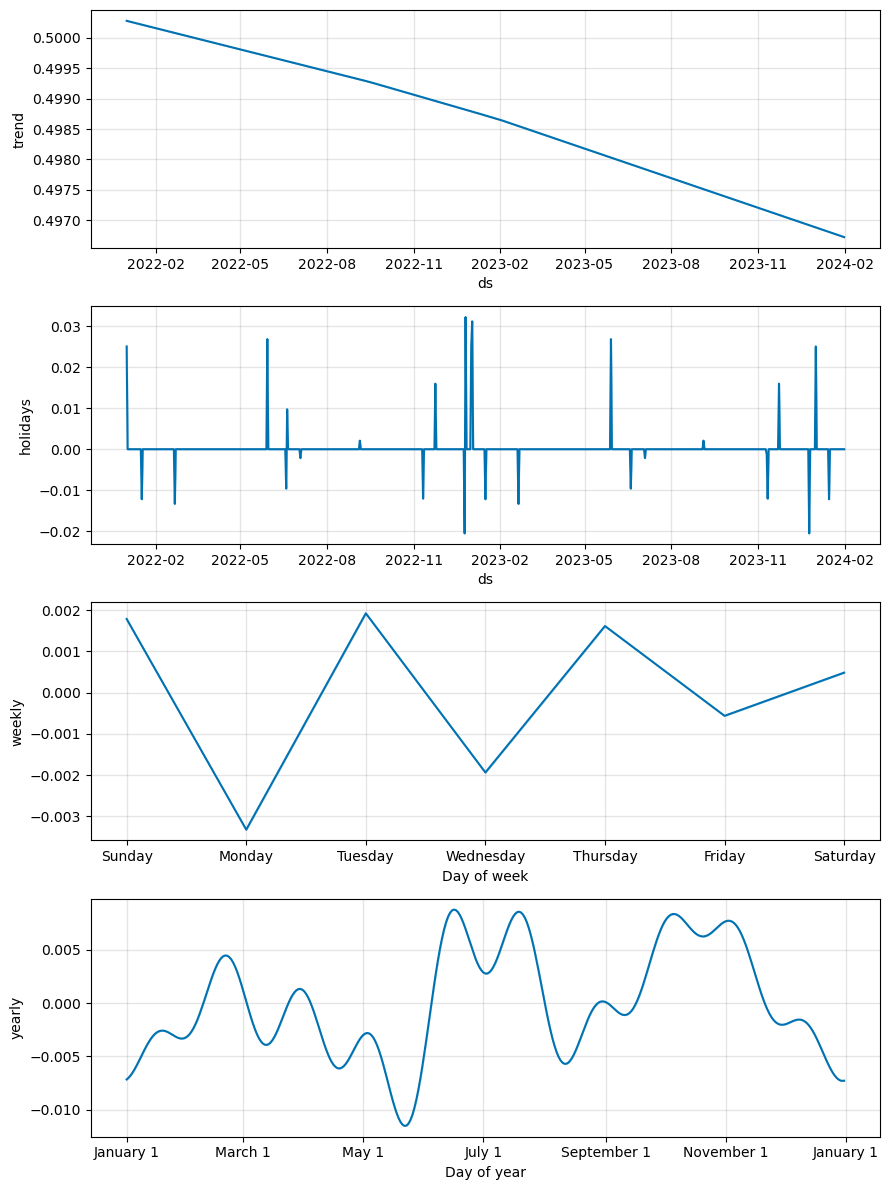

In [20]:
# Cell 11: Prophet Model with Updated 10% Reduction Threshold
from prophet import Prophet

# Prepare the data for Prophet
inventory_data = df.groupby('Date')['Inventory Level'].mean().reset_index()
inventory_data.rename(columns={'Date': 'ds', 'Inventory Level': 'y'}, inplace=True)

# Initialize and train the Prophet model
prophet_model = Prophet(yearly_seasonality=True, daily_seasonality=False)
prophet_model.add_country_holidays(country_name='US')  # Include holiday effects
prophet_model.fit(inventory_data)

# Create future dates and forecast
future = prophet_model.make_future_dataframe(periods=30)
forecast = prophet_model.predict(future)

# Calculate the dynamic 10% reduction threshold
ten_percent_threshold = inventory_data['y'].max() * 0.1

# Visualization: Forecast with 10% Reduction Threshold
fig = prophet_model.plot(forecast)
plt.axhline(ten_percent_threshold, color='red', linestyle='--', label="10% Reduction Threshold")
plt.title("Prophet Inventory Forecast with 10% Reduction Threshold", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Inventory Level", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

# Visualization: Forecast Components
fig2 = prophet_model.plot_components(forecast)
plt.tight_layout()
plt.show()


Training and Testing metrics

test visualization

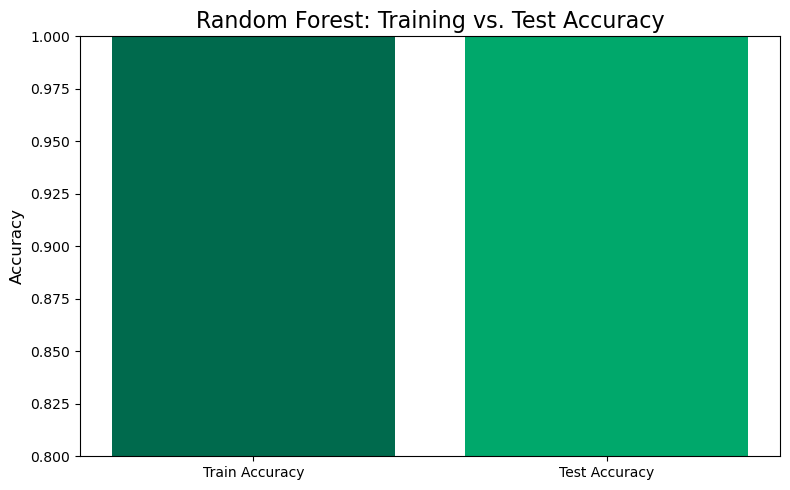

In [10]:
# Cell 12: Training vs. Test Accuracy for Random Forest
train_accuracy_rf = rf_clf.score(X_train, y_train_classification)
test_accuracy_rf = rf_clf.score(X_test, y_test_classification)

plt.figure(figsize=(8, 5))
plt.bar(['Train Accuracy', 'Test Accuracy'], [train_accuracy_rf, test_accuracy_rf], color=[niner_green, emerald_green])
plt.title("Random Forest: Training vs. Test Accuracy", fontsize=16)
plt.ylim(0.8, 1.0)
plt.ylabel("Accuracy", fontsize=12)
plt.tight_layout()
plt.show()


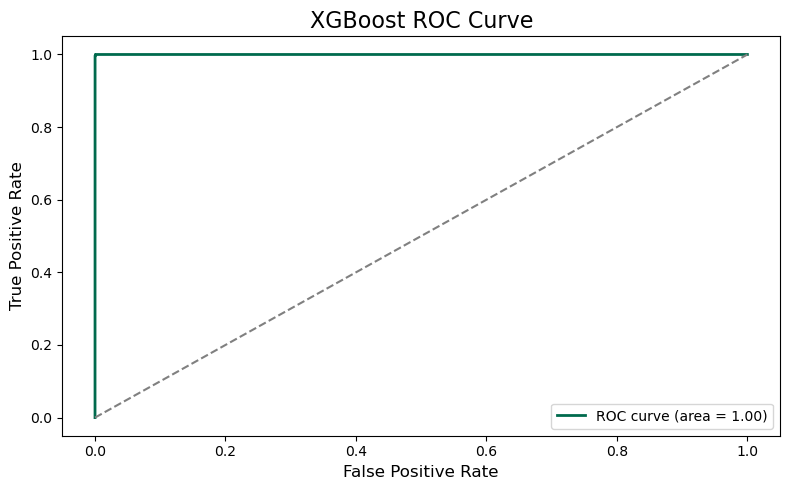

In [11]:
# Cell 13: ROC Curve for XGBoost
from sklearn.metrics import roc_curve, auc

y_pred_proba_xgb = xgb_clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_classification, y_pred_proba_xgb)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color=niner_green, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title("XGBoost ROC Curve", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


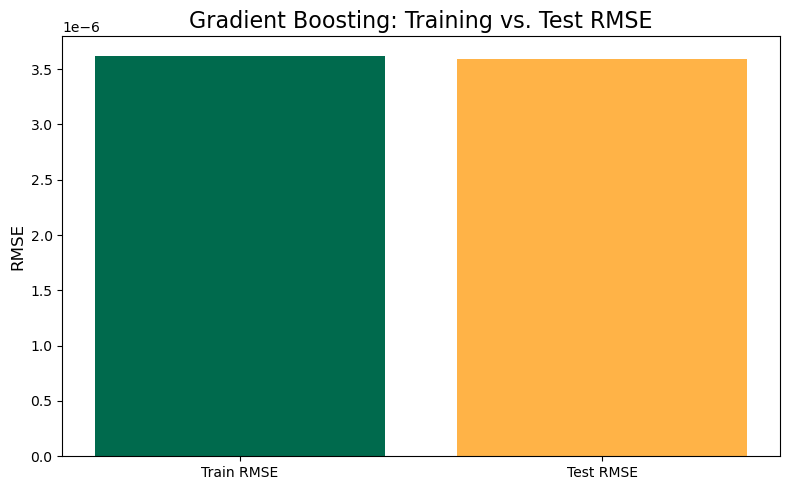

In [21]:
# Cell 14: Training vs. Test RMSE for Gradient Boosting Regressor
train_rmse_gbr = mean_squared_error(y_train_regression, gbr.predict(X_train))
test_rmse_gbr = mean_squared_error(y_test_regression, y_pred_gbr)

plt.figure(figsize=(8, 5))
plt.bar(['Train RMSE', 'Test RMSE'], [train_rmse_gbr, test_rmse_gbr], color=[niner_green, amber])
plt.title("Gradient Boosting: Training vs. Test RMSE", fontsize=16)
plt.ylabel("RMSE", fontsize=12)
plt.tight_layout()
plt.show()


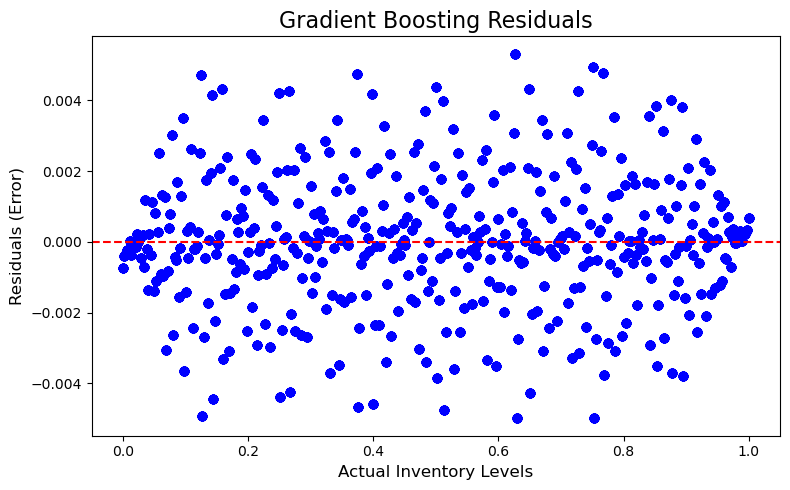

In [13]:
# Cell 15: Residual Plot for Gradient Boosting
residuals = y_test_regression - y_pred_gbr

plt.figure(figsize=(8, 5))
plt.scatter(y_test_regression, residuals, alpha=0.6, c='blue')
plt.axhline(0, color='red', linestyle='--')
plt.title("Gradient Boosting Residuals", fontsize=16)
plt.xlabel("Actual Inventory Levels", fontsize=12)
plt.ylabel("Residuals (Error)", fontsize=12)
plt.tight_layout()
plt.show()
